In [77]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import datetime
import pandas as pd
from PIL import Image

In [78]:
#Getting the filepaths for train and test data
train_files=['dataset/data/patches/train/'+filename for filename in os.listdir('dataset/data/patches/train')]
test_files=['dataset/data/patches/test/'+filename for filename in os.listdir('dataset/data/patches/test')]
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [79]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Assuming train_files and test_files are lists containing file paths

BATCH_SIZE = 64
NOISE_LEVELS=[15,20] 

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        image_decoded = Image.open(file_path).convert('RGB')
        image = transforms.ToTensor()(image_decoded)
        noise_level = np.random.choice(NOISE_LEVELS)
        noise = torch.randn(image.size()) * noise_level / 255.
        noisy_image = torch.clamp(image + noise, 0., 1.)
        return noisy_image, image

# Create dataset instances
train_dataset = CustomDataset(train_files)
test_dataset = CustomDataset(test_files)

# Create DataLoader instances for batching
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



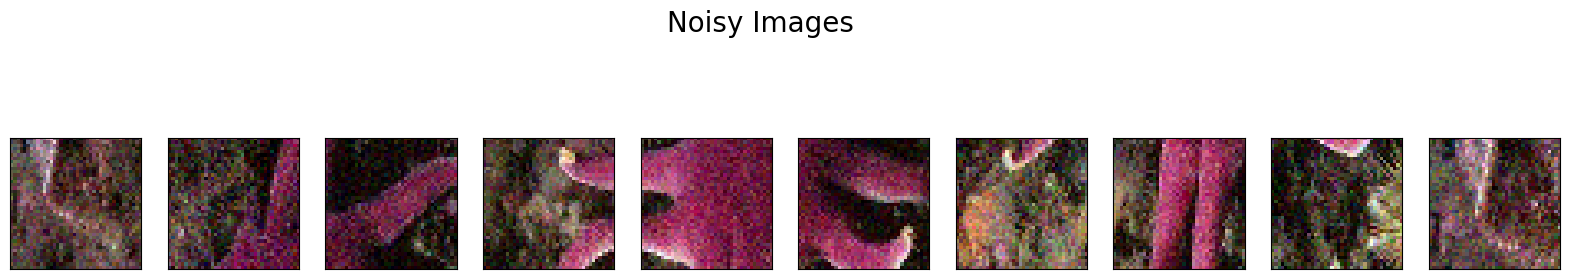

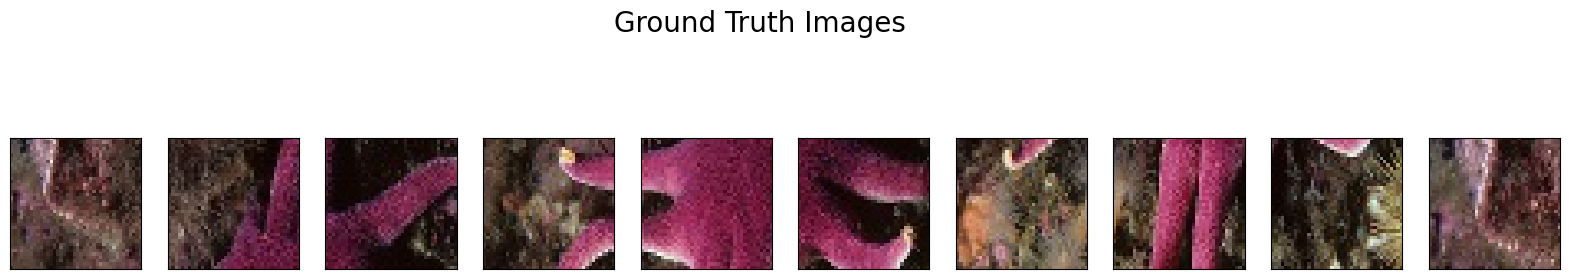

In [80]:
fig, axs = plt.subplots(1, 10, figsize=(20, 4))
for i, (noisy_images, _) in enumerate(train_data_loader):
    if i == 0:  # Only plot the first batch
        for j in range(10):
            axs[j].imshow(noisy_images[j].permute(1, 2, 0))
            axs[j].get_xaxis().set_visible(False)
            axs[j].get_yaxis().set_visible(False)
        fig.suptitle('Noisy Images', fontsize=20)
        plt.show()
        break

fig, axs = plt.subplots(1, 10, figsize=(20, 4))
for i, (_, clean_images) in enumerate(train_data_loader):
    if i == 0:  # Only plot the first batch
        for j in range(10):
            axs[j].imshow(clean_images[j].permute(1, 2, 0))
            axs[j].get_xaxis().set_visible(False)
            axs[j].get_yaxis().set_visible(False)
        fig.suptitle('Ground Truth Images', fontsize=20)
        plt.show()
        break

In [81]:
def get_patches(file_name,patch_size,crop_sizes):
    '''This functions creates and return patches of given image with a specified patch_size'''
    image = cv2.imread(file_name) 
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    height, width , channels= image.shape
    patches = []
    for crop_size in crop_sizes: #We will crop the image to different sizes
        crop_h, crop_w = int(height*crop_size),int(width*crop_size)
        image_scaled = cv2.resize(image, (crop_w,crop_h), interpolation=cv2.INTER_CUBIC)
        for i in range(0, crop_h-patch_size+1, patch_size):
            for j in range(0, crop_w-patch_size+1, patch_size):
              x = image_scaled[i:i+patch_size, j:j+patch_size] # This gets the patch from the original image with size patch_size x patch_size
              patches.append(x)
    return patches

def create_image_from_patches(patches,image_shape):
  '''This function takes the patches of images and reconstructs the image'''
  image=np.zeros(image_shape) # Create a image with all zeros with desired image shape
  patch_size=patches.shape[2]
  p=0
  for i in range(0,image.shape[0]-patch_size+1,patch_size):
    for j in range(0,image.shape[1]-patch_size+1,patch_size):
      image[i:i+patch_size,j:j+patch_size]=patches[p] # Assigning values of pixels from patches to image
      p+=1
  return np.array(image)

def predict_fun(model, image_path, noise_level=30):
    model.eval()
    with torch.no_grad():
        
        # Creating patches for test image
        patches = get_patches(image_path, 40, [1])
        test_image = cv2.imread(image_path)
    
        patches = np.array(patches)
        ground_truth = create_image_from_patches(patches, test_image.shape)
    
        # Predicting the output on the patches of test image
        patches = torch.tensor(patches.astype('float32') / 255.)
        patches_noisy = patches + torch.randn_like(torch.tensor(patches)) * (noise_level / 255.)
        patches_noisy = torch.clamp(patches_noisy, min=0., max=1.)
        noisy_image = create_image_from_patches(patches_noisy, test_image.shape)
    
        # Convert to PyTorch tensors
        patches_noisy = torch.tensor(patches_noisy).permute(0, 3, 1, 2)
        denoised_patches = model(patches_noisy.to(device)).detach().cpu().permute(0, 2, 3, 1).numpy()
        denoised_patches = np.clip(denoised_patches, a_min=0., a_max=1.)
    
        # Creating entire denoised image from denoised patches
        print(denoised_patches.shape,test_image.shape)
        denoised_image = create_image_from_patches(denoised_patches, test_image.shape)
    
        return patches_noisy.permute(0,2,3,1), denoised_patches, ground_truth / 255., noisy_image, denoised_image

def plot_patches(patches_noisy,denoised_patches):
  fig, axs = plt.subplots(2,10,figsize=(20,4))
  for i in range(10):

    axs[0,i].imshow(patches_noisy[i])
    axs[0,i].title.set_text(' Noisy')
    axs[0,i].get_xaxis().set_visible(False)
    axs[0,i].get_yaxis().set_visible(False)

    axs[1,i].imshow(denoised_patches[i])
    axs[1,i].title.set_text('Denoised')
    axs[1,i].get_xaxis().set_visible(False)
    axs[1,i].get_yaxis().set_visible(False)
  plt.show()

def plot_predictions(ground_truth,noisy_image,denoised_image):
  fig, axs = plt.subplots(1,3,figsize=(15,15))
  axs[0].imshow(ground_truth)
  axs[0].title.set_text('Ground Truth')
  axs[1].imshow(noisy_image)
  axs[1].title.set_text('Noisy Image')
  axs[2].imshow(denoised_image)
  axs[2].title.set_text('Denoised Image')
  plt.show()


# #https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
def psnr_np(gt, image, max_value=1):
    """"Function to calculate peak signal-to-noise ratio (PSNR) between two images."""
    mse = np.mean((gt - image) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))
def psnr(batch1, batch2, max_val=1.0):
    batch1 = batch1.float()
    batch2 = batch2.float()
    mse = torch.mean((batch1 - batch2) ** 2, dim=(1, 2, 3))
    psnr_val = 20 * torch.log10(max_val / torch.sqrt(mse))
    return psnr_val.mean()

In [82]:
import torch
import torch.nn as nn

class DnCNN(nn.Module):
    def __init__(self):
        super(DnCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv_layers = self.make_conv_layers(64, 17)
        self.conv_final = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.subtract = Subtract()

    def make_conv_layers(self, channels, num_layers):
        layers = []
        for i in range(num_layers):
            layers.append(nn.Conv2d(channels, channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(channels))
            layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv_layers(out)
        out = self.conv_final(out)
        out = self.subtract(x, out)
        return out

class Subtract(nn.Module):
    def __init__(self):
        super(Subtract, self).__init__()

    def forward(self, x, y):
        return x - y


In [83]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from tqdm import tqdm

def train_model(model, train_loader, num_epochs=40, lr=1e-3, save_path='best_model_dncnn.pth'):
    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = ExponentialLR(optimizer, gamma=0.95)
    
    best_loss = float('inf')
    epoch_losses = []
    epoch_psnrs = []
    learning_rates = []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        total_psnr = 0.0
        
        for i, (inputs, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            total_psnr += psnr(outputs, targets)
        
        # Compute average epoch loss and PSNR
        avg_epoch_loss = epoch_loss / len(train_loader)
        avg_psnr = total_psnr / len(train_loader)
        
        # Record epoch, loss, and PSNR
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}, PSNR: {avg_psnr:.2f}")
        epoch_losses.append(avg_epoch_loss)
        epoch_psnrs.append(avg_psnr)
        learning_rates.append(scheduler.get_last_lr()[0])
        
        # Check if current model is the best so far
        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved at {save_path}")
        
        # Adjust learning rate
        scheduler.step()
    return epoch_losses, epoch_psnrs,learing_rates


In [84]:
model = DnCNN().to(device)
epoch_losses, epoch_psnrs,learing_rates = train_model(model,train_data_loader)

Epoch 1/40: 100%|██████████| 269/269 [00:55<00:00,  4.86it/s]


Epoch 1/40, Loss: 0.0066, PSNR: 23.31
Best model saved at best_model_dncnn.pth


Epoch 2/40: 100%|██████████| 269/269 [00:37<00:00,  7.12it/s]


Epoch 2/40, Loss: 0.0044, PSNR: 23.71
Best model saved at best_model_dncnn.pth


Epoch 3/40: 100%|██████████| 269/269 [00:41<00:00,  6.45it/s]


Epoch 3/40, Loss: 0.0032, PSNR: 25.18
Best model saved at best_model_dncnn.pth


Epoch 4/40: 100%|██████████| 269/269 [00:37<00:00,  7.25it/s]


Epoch 4/40, Loss: 0.0024, PSNR: 26.41
Best model saved at best_model_dncnn.pth


Epoch 5/40: 100%|██████████| 269/269 [00:42<00:00,  6.35it/s]


Epoch 5/40, Loss: 0.0021, PSNR: 26.96
Best model saved at best_model_dncnn.pth


Epoch 6/40: 100%|██████████| 269/269 [00:37<00:00,  7.21it/s]


Epoch 6/40, Loss: 0.0019, PSNR: 27.31
Best model saved at best_model_dncnn.pth


Epoch 7/40: 100%|██████████| 269/269 [00:44<00:00,  5.99it/s]


Epoch 7/40, Loss: 0.0018, PSNR: 27.60
Best model saved at best_model_dncnn.pth


Epoch 8/40: 100%|██████████| 269/269 [00:37<00:00,  7.17it/s]


Epoch 8/40, Loss: 0.0017, PSNR: 28.06
Best model saved at best_model_dncnn.pth


Epoch 9/40: 100%|██████████| 269/269 [00:47<00:00,  5.67it/s]


Epoch 9/40, Loss: 0.0016, PSNR: 28.30
Best model saved at best_model_dncnn.pth


Epoch 10/40: 100%|██████████| 269/269 [00:38<00:00,  7.01it/s]


Epoch 10/40, Loss: 0.0015, PSNR: 28.55
Best model saved at best_model_dncnn.pth


Epoch 11/40: 100%|██████████| 269/269 [00:49<00:00,  5.45it/s]


Epoch 11/40, Loss: 0.0015, PSNR: 28.65
Best model saved at best_model_dncnn.pth


Epoch 12/40: 100%|██████████| 269/269 [00:36<00:00,  7.30it/s]


Epoch 12/40, Loss: 0.0014, PSNR: 28.80
Best model saved at best_model_dncnn.pth


Epoch 13/40: 100%|██████████| 269/269 [00:42<00:00,  6.30it/s]


Epoch 13/40, Loss: 0.0014, PSNR: 28.87
Best model saved at best_model_dncnn.pth


Epoch 14/40: 100%|██████████| 269/269 [00:37<00:00,  7.25it/s]


Epoch 14/40, Loss: 0.0016, PSNR: 28.32


Epoch 15/40: 100%|██████████| 269/269 [00:42<00:00,  6.36it/s]


Epoch 15/40, Loss: 0.0014, PSNR: 28.83


Epoch 16/40: 100%|██████████| 269/269 [00:38<00:00,  7.04it/s]


Epoch 16/40, Loss: 0.0014, PSNR: 28.98
Best model saved at best_model_dncnn.pth


Epoch 17/40: 100%|██████████| 269/269 [00:41<00:00,  6.43it/s]


Epoch 17/40, Loss: 0.0013, PSNR: 29.06
Best model saved at best_model_dncnn.pth


Epoch 18/40: 100%|██████████| 269/269 [00:36<00:00,  7.27it/s]


Epoch 18/40, Loss: 0.0013, PSNR: 29.11
Best model saved at best_model_dncnn.pth


Epoch 19/40: 100%|██████████| 269/269 [00:43<00:00,  6.21it/s]


Epoch 19/40, Loss: 0.0013, PSNR: 29.22
Best model saved at best_model_dncnn.pth


Epoch 20/40: 100%|██████████| 269/269 [00:37<00:00,  7.23it/s]


Epoch 20/40, Loss: 0.0013, PSNR: 29.30
Best model saved at best_model_dncnn.pth


Epoch 21/40: 100%|██████████| 269/269 [00:44<00:00,  6.01it/s]


Epoch 21/40, Loss: 0.0013, PSNR: 29.35
Best model saved at best_model_dncnn.pth


Epoch 22/40: 100%|██████████| 269/269 [00:37<00:00,  7.18it/s]


Epoch 22/40, Loss: 0.0013, PSNR: 29.42
Best model saved at best_model_dncnn.pth


Epoch 23/40: 100%|██████████| 269/269 [00:46<00:00,  5.80it/s]


Epoch 23/40, Loss: 0.0012, PSNR: 29.45
Best model saved at best_model_dncnn.pth


Epoch 24/40: 100%|██████████| 269/269 [00:37<00:00,  7.26it/s]


Epoch 24/40, Loss: 0.0012, PSNR: 29.48
Best model saved at best_model_dncnn.pth


Epoch 25/40: 100%|██████████| 269/269 [00:45<00:00,  5.94it/s]


Epoch 25/40, Loss: 0.0012, PSNR: 29.53
Best model saved at best_model_dncnn.pth


Epoch 26/40:  41%|████▏     | 111/269 [00:15<00:22,  6.94it/s]


RuntimeError: CUDA out of memory. Tried to allocate 26.00 MiB (GPU 0; 11.91 GiB total capacity; 8.82 GiB already allocated; 3.62 MiB free; 8.85 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
patches_noisy,denoised_patches,ground_truth,noisy_image,denoised_image=predict_fun(model,'dataset/data/test/0820.jpg',noise_level=20)
print('PSNR of Noisy Image : ',psnr_np(ground_truth,noisy_image))
print('PSNR of Denoised Image : ',psnr_np(ground_truth,denoised_image))
plot_patches(patches_noisy,denoised_patches)

In [ ]:
plot_predictions(ground_truth,noisy_image,denoised_image)